### Mount drive

Because `Detectron2` needs a GPU, this implimentation has been developed on Google Colab so the GPU could be utilized. In order to use this repo, please make a shortcut to this drive and mount this file. 

_*Note: You will need to change the `%cd` command to point to the location of your shortcut. This is because the new object dataset (ballons) is stored on this drive. You get access to this dataset, you'll need to make a shortcut link to this drive, or download that dataset to your own machine/drive._

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/CS6510
### ^^^ Change me ^^^
%ls .

/content/drive/MyDrive/CS6510
balloon/  detectron2/  _Detectron2/  output/  problem08_part_d.ipynb


## Setup

This section handels the downloading/instilation of Detectron2 and importing nesessary libraries. Also, some helperfuction are made here for setting up the file structure for training.

### Install Detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [4]:
import pandas as pd
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation
import torch # PyTorch package
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision # load datasets

import sys, os, distutils.core
from detectron2.utils.logger import setup_logger
setup_logger()

import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from google.colab.patches import cv2_imshow

import torchvision.transforms as transforms 
from sklearn.model_selection import train_test_split
import json, cv2, random

### Helper/utility functions

Create a registry of files in the new object dataset (both training and validation). Also makes a fallback render config to help pretty print prediction outputs for retinanet (because it can being dramatic).

In [69]:
def get_balloon_dicts(img_dir):
    f = open(os.path.join(img_dir, "via_region_data.json"))
    imgs_anns = json.load(f)
    f.close()

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        objs = []
        for _, anno in v["regions"].items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

  
file1 = "COCO-Detection/retinanet_R_50_FPN_3x.yaml"

cfg_default = get_cfg()   # get a fresh new config
cfg_default.merge_from_file(model_zoo.get_config_file(file1))
cfg_default.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg_default.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(file1)

### Check Images

Double check that everthing is working so far and see the new objects and bounding boxes.


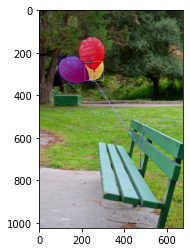

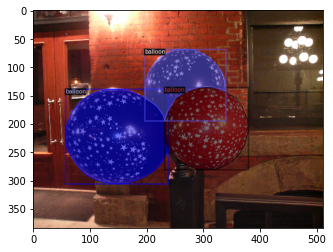

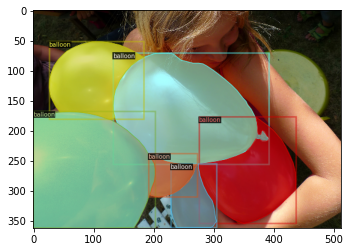

In [115]:
try:
  for d in ["train", "val"]:
      DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
      MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
  balloon_metadata = MetadataCatalog.get("balloon_train")
except: ...
# verity the dataset
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure()
    # cv2_imshow(out.get_image()[:, :, ::-1])
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB))
    plt.show()

## Training

Here, we draft up a quick traiing regiment with the training partition and run the 3 models (Mask, Faster, and Retinanet R-CNNs) through each. The weight are sent off to the testing section.

In [ ]:
def train_segmentation(config_file):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_file))
    cfg.DATASETS.TRAIN = ("balloon_train",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()
    return cfg

cfg1 = train_segmentation('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml')
cfg2 = train_segmentation('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg3 = train_segmentation('COCO-Detection/retinanet_R_50_FPN_3x.yaml')

## Testing

This section containes the code snippits to show the prediction outputs of the 3 model types (Mask, Faster, and Retinanet R-CNNs). First we maually review 3 images passed through each of the models. Then we test them against the validation partition.

In [ ]:
def creat_predictor(cfg):
    # Inference should use the config with parameters that are used in training
    # cfg now already contains everything we've set previously. We changed it a little bit for inference:
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)
    return predictor

predictor1=creat_predictor(cfg1)
predictor2=creat_predictor(cfg2)
predictor3=creat_predictor(cfg3)

#### Visulize results

Manual check the output of the various models and make sure they pass a sniff test.



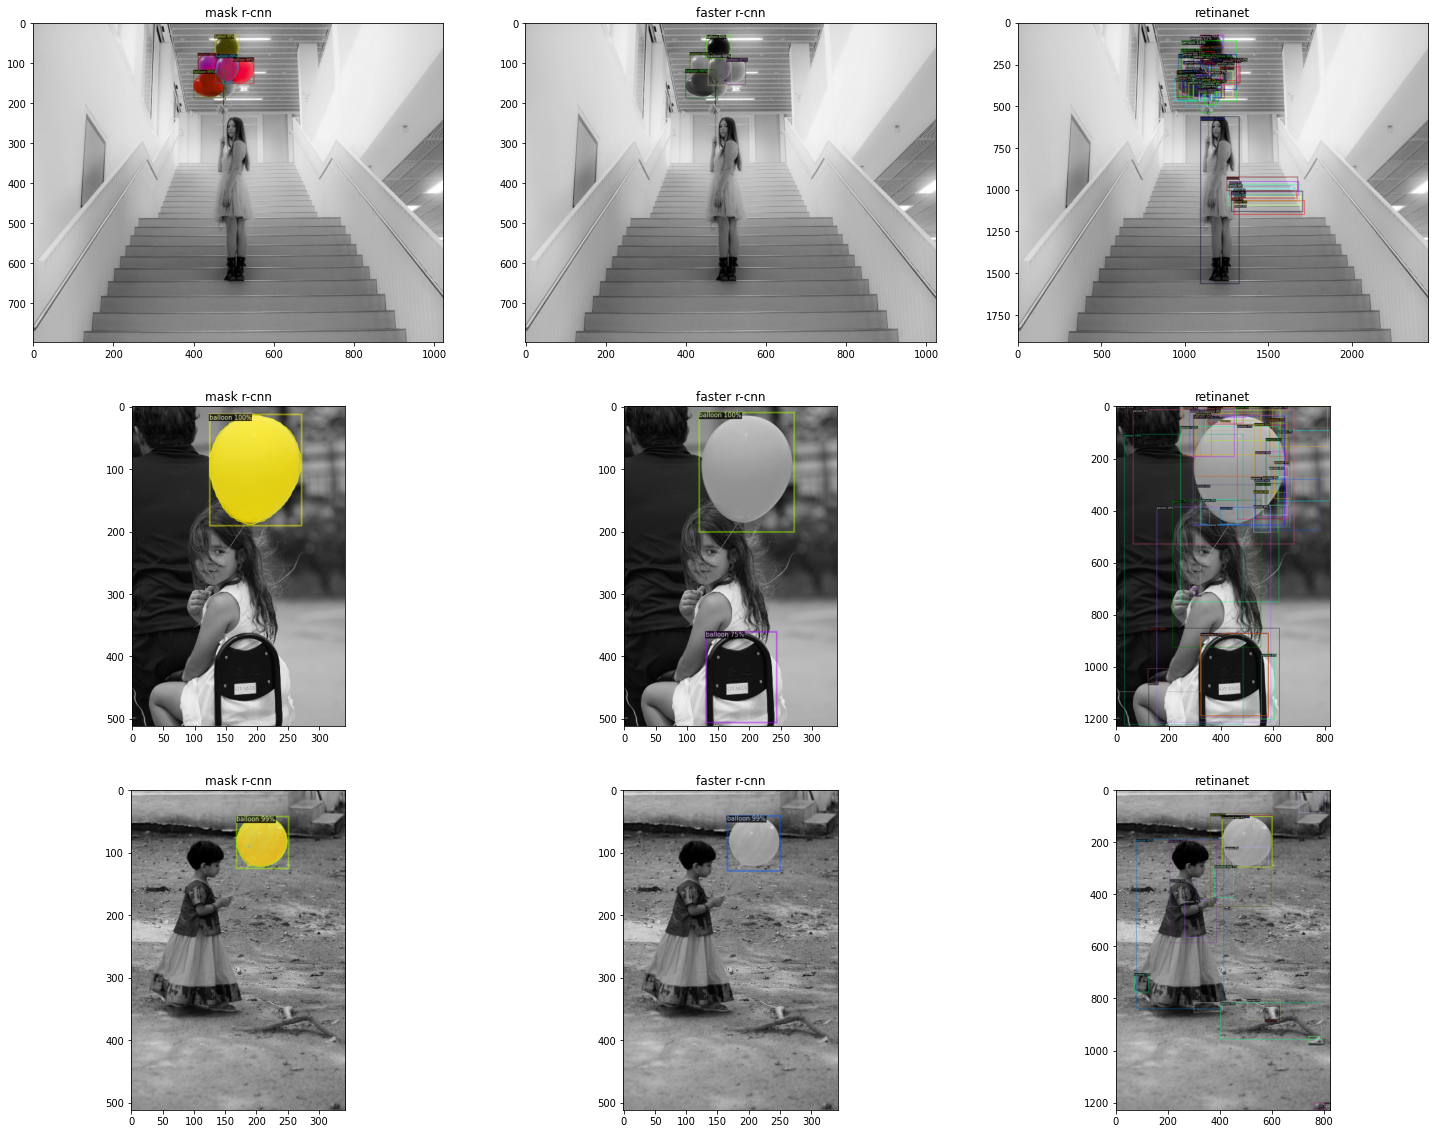

In [114]:
dataset_dicts = get_balloon_dicts("balloon/val")
fig, axs = plt.subplots(3,3,figsize=(25,20))
for i,d in enumerate(random.sample(dataset_dicts, 3)):
  # for j,(predictor,title) in enumerate([(predictor1,'mask r-cnn'), (predictor2,'faster r-cnn'), (predictor3,'retinanet')]):
  for j,(predictor,title) in enumerate([(predictor1,'mask r-cnn'), (predictor2,'faster r-cnn'), (predictor3,'retinanet')]):
  # for j,(predictor,title) in enumerate([(predictor3,'retinanet')]):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    if j==2: v = Visualizer(img[:,:,::-1], metadata=MetadataCatalog.get(cfg_default.DATASETS.TRAIN[0]), scale=1.2, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # cv2_imshow(out.get_image()[:, :, ::-1])
    axs[i][j].imshow(cv2.cvtColor(out.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB))
    # plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB))
    axs[i][j].set_title(title)
plt.show()

### Scoring using the validation partition

First block we run a quick validation set against each of the models. Then we pretty print the relivant result metrics.

In [ ]:
def evaluate(cfg,predictor):
    evaluator = COCOEvaluator("balloon_val", output_dir="./output")
    val_loader = build_detection_test_loader(cfg, "balloon_val")
    out = inference_on_dataset(predictor.model, val_loader, evaluator)
    return out

results = [
    ('Mask R-CNN',evaluate(cfg1,predictor1)),
    ('Faster R-CNN',evaluate(cfg2,predictor2)),
    ('Retinanet R-CNN',evaluate(cfg3,predictor3))]

In [113]:
for name, out in results:
    print(f'{name}:')
    for label, n in out['bbox'].items():
        print("\t{label:5}: {n:0.5}".format(label=label,n=n))
    print()

Mask R-CNN:
	AP   : 72.353
	AP50 : 83.93
	AP75 : 80.06
	APs  : 0.0
	APm  : 53.85
	APl  : 89.159

Faster R-CNN:
	AP   : 66.872
	AP50 : 83.953
	AP75 : 83.953
	APs  : 0.0
	APm  : 53.972
	APl  : 81.116

Retinanet R-CNN:
	AP   : 74.573
	AP50 : 87.853
	AP75 : 83.185
	APs  : 30.297
	APm  : 60.919
	APl  : 88.706

